## Create the K-Means Geospatial Algorithm And Apply It To The Data

In [21]:
%store -r long_lat

# for machine learning
from sklearn import preprocessing, cluster
import scipy
import folium

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Set number of clusters *k* at 5
k = 15

# Initialize k-means model
model = cluster.KMeans(n_clusters=k, init='k-means++')

# clustering
X = long_lat[["Latitude","Longitude"]]

dtf_X = X.copy()

# find real centroids
dtf_X["cluster"] = model.fit_predict(X)

closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)

dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1  

# add clustering info to the original dataset
long_lat[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]

long_lat.sample(5)

# View number of addresses in each cluster grouping
(pd.DataFrame(long_lat.groupby('cluster')['Address'].count())
   .rename(columns = {'Address':'Count'})
   .reset_index()
   .sort_values('Count', ascending = False)
)

cluster  Count
5         5    650
14       14    455
1         1    449
11       11    420
2         2    404
7         7    401
13       13    389
9         9    373
0         0    345
3         3    234
12       12    231
10       10    158
6         6    113
8         8     53
4         4      1

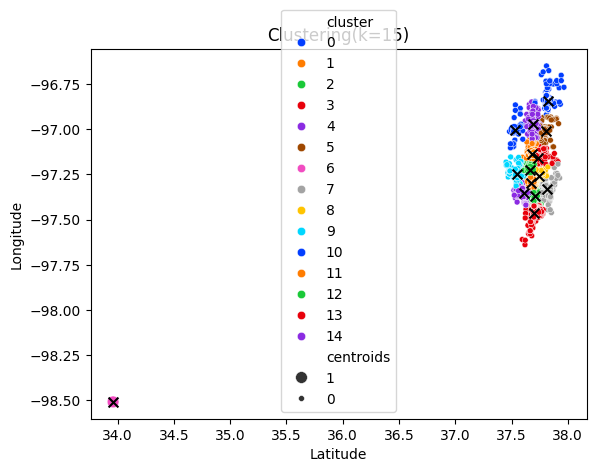

In [16]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="Latitude", y="Longitude", data=long_lat, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering(k=' + str(k) + ')')

th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")


In [17]:
model = cluster.AffinityPropagation()

### Plot the K-Means Clusters On The Geospatial Map

In [28]:
%store -r lst_elements
%store -r location

# Create objects for ploting
x, y = 'Latitude', 'Longitude'
color = 'cluster'
size = 'Count'
popup = 'Address'
marker = 'centroids'
data = long_lat.copy()

# create color column
lst_elements = sorted(list(long_lat[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))]
data['color'] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

# create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range = (300, 1000))
data['size'] = scaler.fit_transform(data[size].values.reshape(-1, 1)).reshape(-1)

# Initialize the map with the starting location
map_ = folium.Map(location = location, tiles = 'cartodbpositron', zoom_start = 11)

# add points
data.apply(lambda row: folium.CircleMarker(location = [row[x], row[y]], popup = row[popup],
                                           color = row['color'], fill = True,
                                           size = row['size']).add_to(map_), axis = 1)

# add html legend
legend_html = """<div style = "position:fixed; bottom:10px; left:10px; border:2px solid black; 
                z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b>
                <br>"""

for i in lst_elements:
    legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
                              fa-1x" style = "color:"""+lst_colors[lst_elements.index(i)]+"""">
                              </i>&nbsp;"""+str(i)+"""<br>"""

legend_html = legend_html+"""</div>"""

lst_elements = sorted(list(long_lat[marker].unique()))
data[data[marker]==1].apply(lambda row: folium.Marker(location = [row[x], row[y]], popup = row[marker], draggable = False, icon = folium.Icon(color = 'black')).add_to(map_), axis =1)
map_.get_root().html.add_child(folium.Element(legend_html))

# plot the map

map_

In [ ]:
long_lat.to_csv('K-Means_202310.csv', index = False, header=True)